# Marathon Predictor

__Objective 1:__ Are variations in average marathon times connected to weather conditions and course elevation changes?

__Objective 2:__ Are winning marathon times connected to weather and elevation to the same extent that average runner times are?

__Objective 3:__ How can an average runner adjust their pacing plan to account for race day conditions and run a smart marathon?

### Import packages

In [1]:
import pandas as pd
import numpy as np
import math
import time
import os
import re

from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
from matplotlib.ticker import FuncFormatter
from matplotlib.offsetbox import AnchoredText
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

pd.options.mode.chained_assignment = None  # default='warn'

%matplotlib widget

### Load full data

In [2]:
# Load full data
directory = 'full_df_csvs'
newest_full_df = [file for file in sorted(os.listdir(directory)) if file.endswith('.csv')][-1]
full_df = pd.read_csv(os.path.join(directory, newest_full_df))

# Update data types
full_df['Date'] = pd.to_datetime(full_df['Date'])
time_cols = ['Male Win','Female Win','Average Time','Time STD']
full_df[time_cols] = (full_df[time_cols].apply(pd.to_timedelta))

# full_df.dtypes

In [3]:
# Feature Variables
X = full_df[['Event Name', 'City', 'State', 
            'Date', 
            'Finishers', 'Males', 'Females', 'Percent Female',
            'Elev Gain', 'Elev Loss', 'Elev Max', 'Elev Min', 
            'STATION', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 
            'TEMP', 'MAX', 'MIN', 'PRCP', 'DEWP', 'WDSP', 'RELHUM']]
# Dates will be in days (float) since Jan 1, 2000
X['Date'] = (pd.to_datetime(X['Date']) - pd.to_datetime('2000-01-01'))/np.timedelta64(1, 'D')

# Target Variables: Run times will be in seconds (float)
y_average = full_df['Average Time'] / np.timedelta64(1, 's')
y_male = full_df['Male Win'] / np.timedelta64(1, 's')
y_female = full_df['Female Win'] / np.timedelta64(1, 's')

### Exploratory Data Visualization

In [4]:
# Create a formatter for reading plot axes as h:mm or h:mm:ss
from matplotlib.ticker import FuncFormatter

def format_func(x, pos):
    hours = int(x//3600)
    minutes = int((x%3600)//60)
    seconds = int(x%60)

    return "{:d}:{:02d}".format(hours, minutes)
    # return "{:d}:{:02d}:{:02d}".format(hours, minutes, seconds)

formatter = FuncFormatter(format_func)

In [5]:
# see available built-in styles.
# plt.style.available

In [6]:
plt.style.use('seaborn-colorblind')

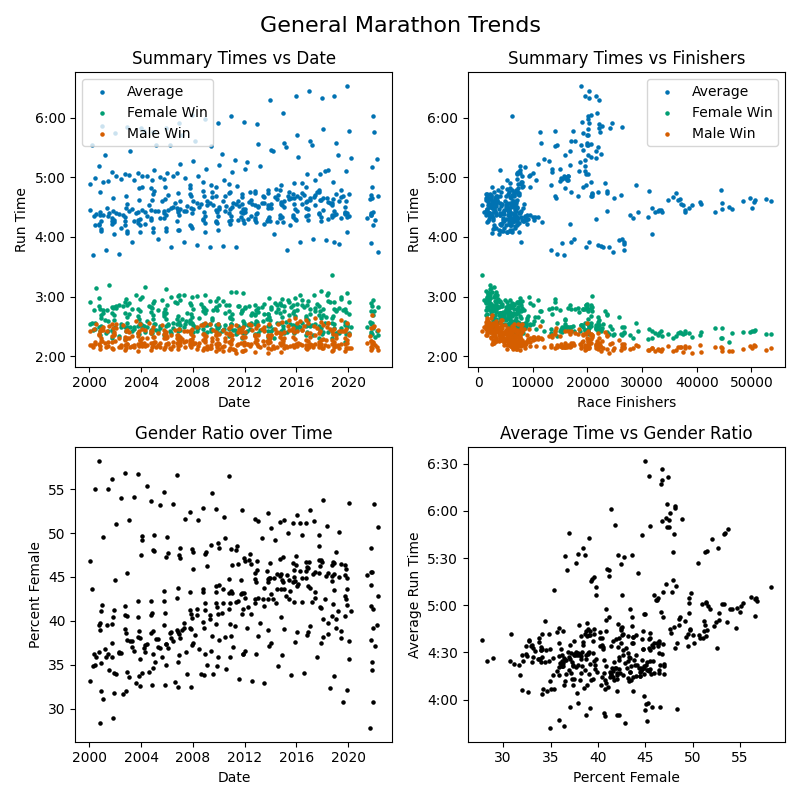

In [7]:
fig, axs = plt.subplots(2,2,figsize=(8,8))
((ax1,ax2),(ax3,ax4)) = axs

ax1.scatter(full_df['Date'],y_average, s=5, label='Average')
ax1.scatter(full_df['Date'],y_female, s=5, label='Female Win')
ax1.scatter(full_df['Date'],y_male, s=5, label='Male Win')
ax1.set_xlabel('Date')
ax1.set_ylabel('Run Time')
ax1.set_title('Summary Times vs Date')

ax2.scatter(full_df['Finishers'],y_average, s=5, label='Average')
ax2.scatter(full_df['Finishers'],y_female, s=5, label='Female Win')
ax2.scatter(full_df['Finishers'],y_male, s=5, label='Male Win')
ax2.set_xlabel('Race Finishers')
ax2.set_ylabel('Run Time')
ax2.set_title('Summary Times vs Finishers')

ax3.scatter(full_df['Date'],full_df['Percent Female'], color='k', s=5, label='_none')
ax3.set_xlabel('Date')
ax3.set_ylabel('Percent Female')
ax3.set_title('Gender Ratio over Time')

ax4.scatter(full_df['Percent Female'],y_average, color='k', s=5, label='Average')
ax4.set_xlabel('Percent Female')
ax4.set_ylabel('Average Run Time')
ax4.set_title('Average Time vs Gender Ratio')

# Set tick labels and legends
for ax in [ax1,ax2]:
    ax.yaxis.set_major_locator(mticker.MultipleLocator(base=3600))
    ax.yaxis.set_major_formatter(formatter)
    ax.legend()
ax4.yaxis.set_major_locator(mticker.MultipleLocator(base=1800))
ax4.yaxis.set_major_formatter(formatter)

fig.suptitle('General Marathon Trends', fontsize=16)
# ax2.xaxis.set_tick_params(rotation=45)
fig.tight_layout()

In [8]:
# Create a comparison of each Marathon based on mean of the Average Times from 2000-2022
event_rank = (full_df.groupby(by=['Event Name'])
                     .agg({'Average Time':np.mean})
                     .sort_values('Average Time')
                     .rename(columns={'Average Time':'Mean of Averages'})
                     .reset_index()
                    )
event_rank = event_rank.merge(full_df[['Event Name','Average Time']], how='inner', on='Event Name')
# print(event_rank.head())

# Convert times to floats for plotting
event_rank[['Average Time','Mean of Averages']] = event_rank[['Average Time','Mean of Averages']] / np.timedelta64(1, 's')
# print(event_rank.head())

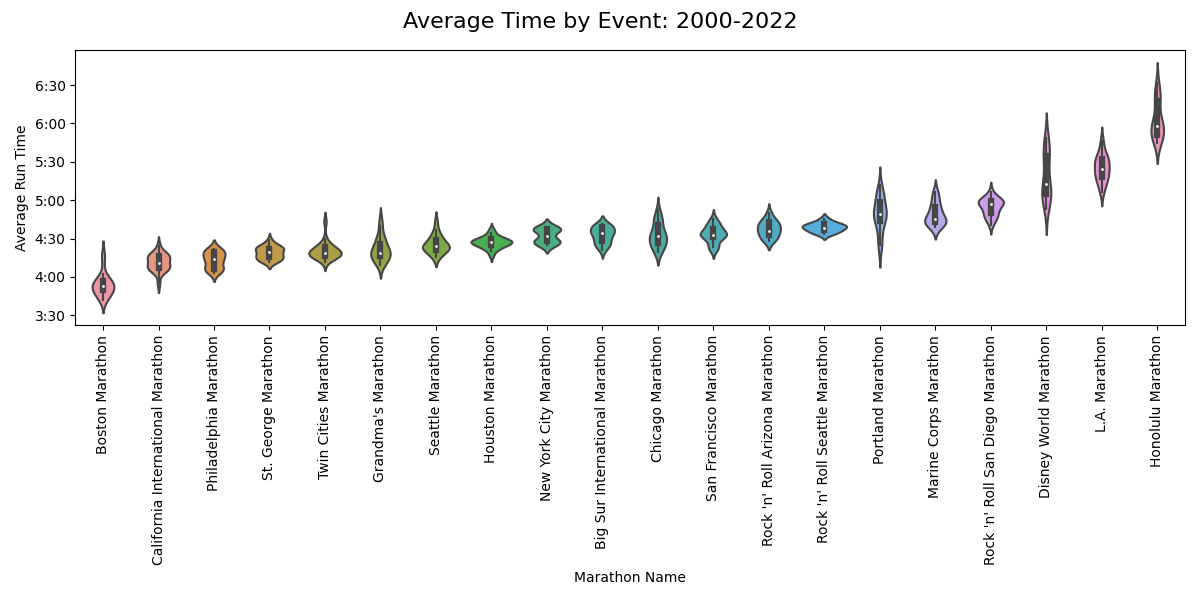

In [9]:
# Comparison of Average Run Time by Event Name
fig, ax1 = plt.subplots(1,1,figsize=(12,6))
sns.violinplot(x='Mean of Averages', y='Average Time', data=event_rank, ax=ax1);

labels = event_rank['Event Name'].unique()
ax1.xaxis.set_ticks(range(len(labels)),labels,rotation=90)
# ax1.xaxis.set_tick_params(rotation=90)
ax1.yaxis.set_major_locator(mticker.MultipleLocator(base=1800))
ax1.yaxis.set_major_formatter(formatter)
ax1.set_ylabel('Average Run Time')
ax1.set_xlabel('Marathon Name')
fig.suptitle('Average Time by Event: 2000-2022', fontsize=16)
fig.tight_layout()

In [10]:
# Create a comparison of each Marathon based on mean of the Female Win times from 2000-2022
event_rank_female = (full_df.groupby(by=['Event Name'])
                     .agg({'Female Win':np.mean})
                     .sort_values('Female Win')
                     .rename(columns={'Female Win':'Mean of Female Wins'})
                     .reset_index()
                    )
event_rank_female = event_rank_female.merge(full_df[['Event Name','Female Win']], how='inner', on='Event Name')
# print(event_rank_female.head())

# Convert times to floats for plotting
event_rank_female[['Female Win','Mean of Female Wins']] = event_rank_female[['Female Win','Mean of Female Wins']] / np.timedelta64(1, 's')
# print(event_rank_female.head())

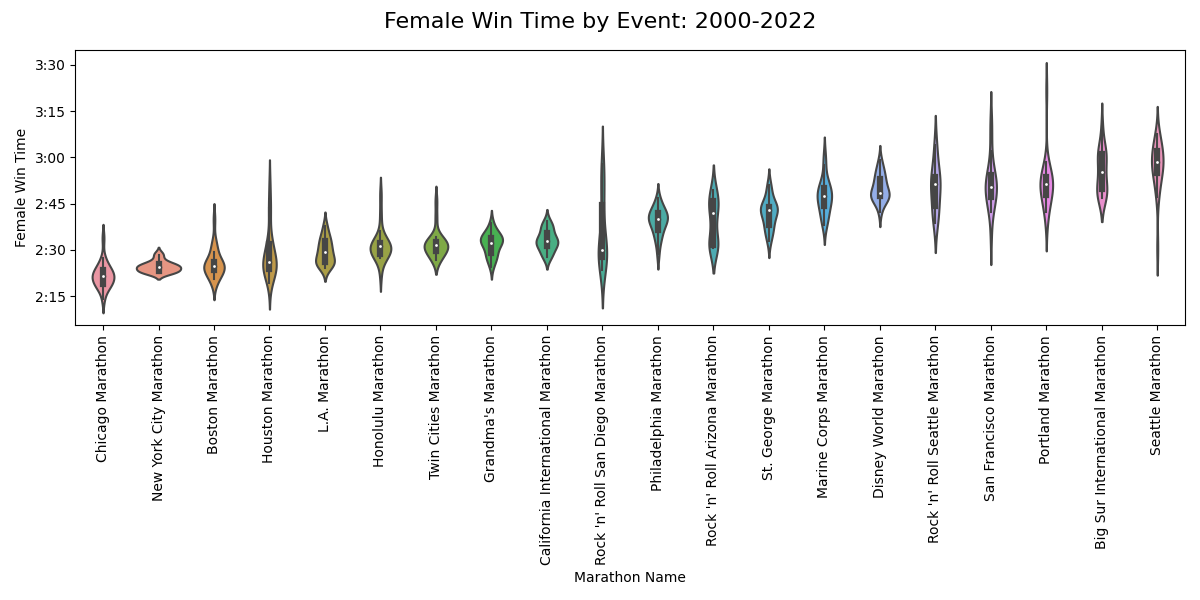

In [11]:
# Comparison of Female Wins by Event Name
fig, ax1 = plt.subplots(1,1,figsize=(12,6))
sns.violinplot(x='Mean of Female Wins', y='Female Win', data=event_rank_female, ax=ax1);

labels = event_rank_female['Event Name'].unique()
ax1.xaxis.set_ticks(range(len(labels)),labels,rotation=90)
# ax1.xaxis.set_tick_params(rotation=90)
ax1.yaxis.set_major_locator(mticker.MultipleLocator(base=900))
ax1.yaxis.set_major_formatter(formatter)
ax1.set_ylabel('Female Win Time')
ax1.set_xlabel('Marathon Name')
fig.suptitle('Female Win Time by Event: 2000-2022', fontsize=16)
fig.tight_layout()

In [12]:
# Create a comparison of each Marathon based on mean of the Male Win times from 2000-2022
event_rank_male = (full_df.groupby(by=['Event Name'])
                     .agg({'Male Win':np.mean})
                     .sort_values('Male Win')
                     .rename(columns={'Male Win':'Mean of Male Wins'})
                     .reset_index()
                    )
event_rank_male = event_rank_male.merge(full_df[['Event Name','Male Win']], how='inner', on='Event Name')
# print(event_rank_male.head())

# Convert times to floats for plotting
event_rank_male[['Male Win','Mean of Male Wins']] = event_rank_male[['Male Win','Mean of Male Wins']] / np.timedelta64(1, 's')
# print(event_rank_male.head())

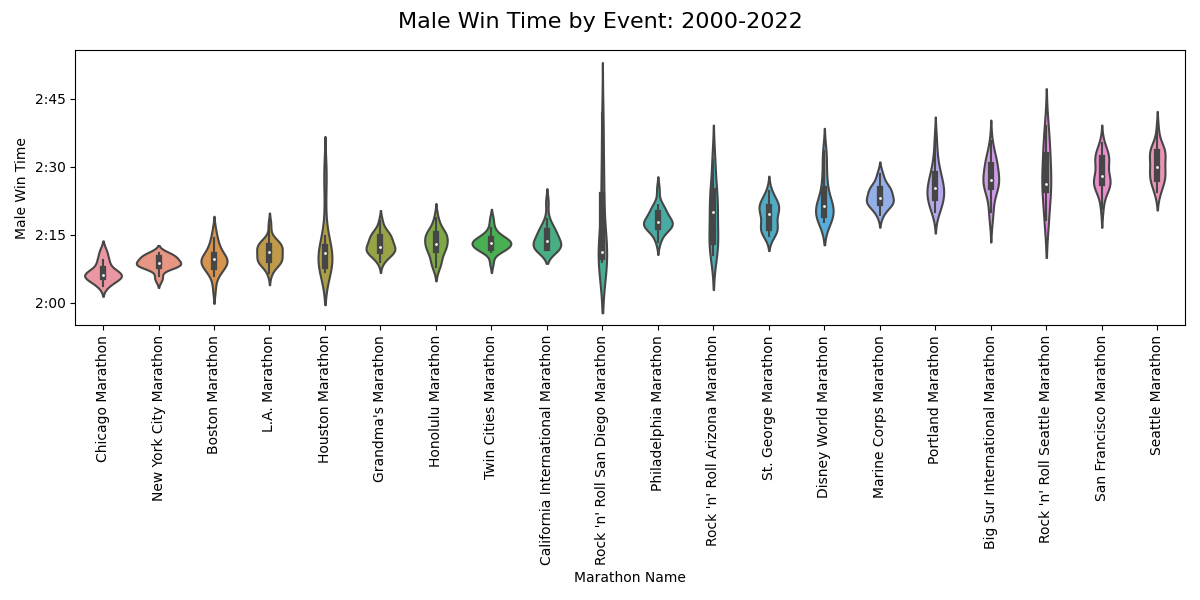

In [13]:
# Comparison of Male Wins by Event Name
fig, ax1 = plt.subplots(1,1,figsize=(12,6))
sns.violinplot(x='Mean of Male Wins', y='Male Win', data=event_rank_male, ax=ax1);

labels = event_rank_male['Event Name'].unique()
ax1.xaxis.set_ticks(range(len(labels)),labels,rotation=90)
# ax1.xaxis.set_tick_params(rotation=90)
ax1.yaxis.set_major_locator(mticker.MultipleLocator(base=900))
ax1.yaxis.set_major_formatter(formatter)
ax1.set_ylabel('Male Win Time')
ax1.set_xlabel('Marathon Name')
fig.suptitle('Male Win Time by Event: 2000-2022', fontsize=16)
fig.tight_layout()

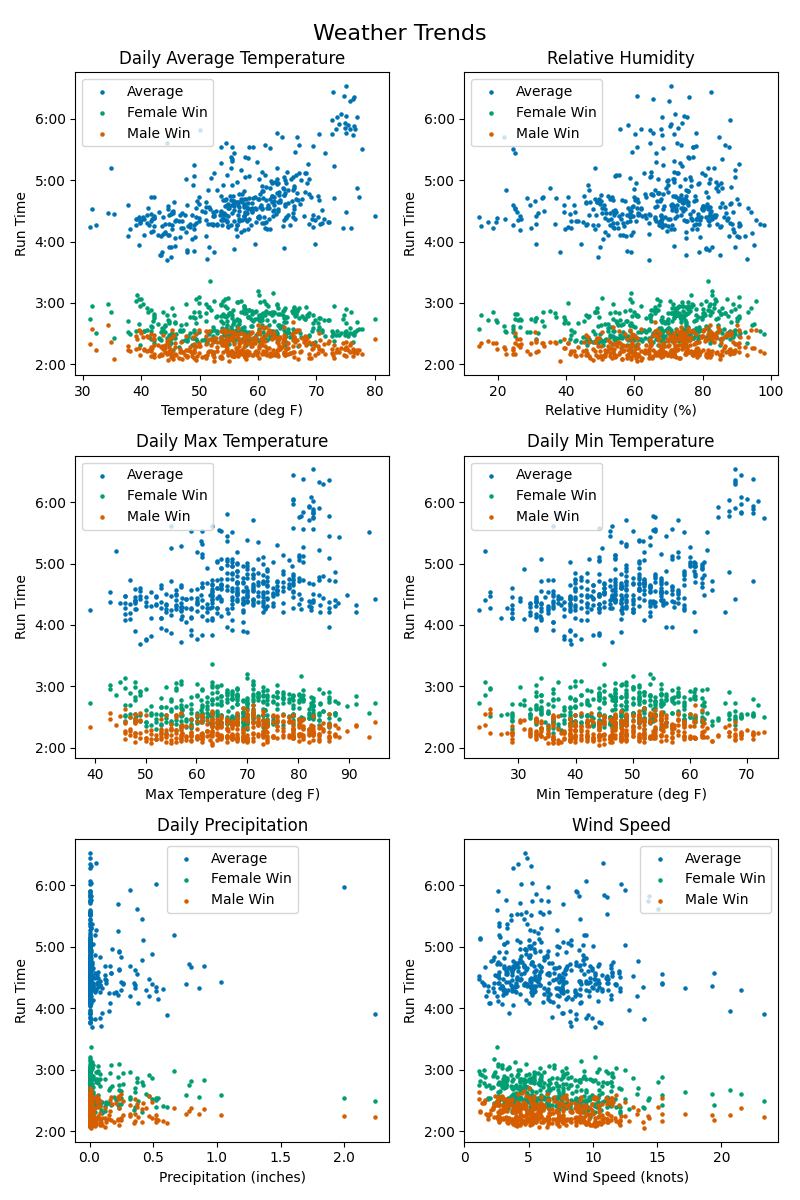

In [14]:
# Plot weather data
# 'TEMP', 'RELHUM',
# 'MAX', 'MIN',
# 'PRCP', 'WDSP'
fig, axs = plt.subplots(3,2,figsize=(8,12))
((ax1,ax2),(ax3,ax4),(ax5,ax6)) = axs

ax1.scatter(full_df['TEMP'],y_average, s=5, label='Average')
ax1.scatter(full_df['TEMP'],y_female, s=5, label='Female Win')
ax1.scatter(full_df['TEMP'],y_male, s=5, label='Male Win')
ax1.set_xlabel('Temperature (deg F)')
ax1.set_ylabel('Run Time')
ax1.set_title('Daily Average Temperature')

ax2.scatter(full_df['RELHUM'],y_average, s=5, label='Average')
ax2.scatter(full_df['RELHUM'],y_female, s=5, label='Female Win')
ax2.scatter(full_df['RELHUM'],y_male, s=5, label='Male Win')
ax2.set_xlabel('Relative Humidity (%)')
ax2.set_ylabel('Run Time')
ax2.set_title('Relative Humidity')

ax3.scatter(full_df['MAX'],y_average, s=5, label='Average')
ax3.scatter(full_df['MAX'],y_female, s=5, label='Female Win')
ax3.scatter(full_df['MAX'],y_male, s=5, label='Male Win')
ax3.set_xlabel('Max Temperature (deg F)')
ax3.set_ylabel('Run Time')
ax3.set_title('Daily Max Temperature')

ax4.scatter(full_df['MIN'],y_average, s=5, label='Average')
ax4.scatter(full_df['MIN'],y_female, s=5, label='Female Win')
ax4.scatter(full_df['MIN'],y_male, s=5, label='Male Win')
ax4.set_xlabel('Min Temperature (deg F)')
ax4.set_ylabel('Run Time')
ax4.set_title('Daily Min Temperature')

ax5.scatter(full_df['PRCP'],y_average, s=5, label='Average')
ax5.scatter(full_df['PRCP'],y_female, s=5, label='Female Win')
ax5.scatter(full_df['PRCP'],y_male, s=5, label='Male Win')
ax5.set_xlabel('Precipitation (inches)')
ax5.set_ylabel('Run Time')
ax5.set_title('Daily Precipitation')

ax6.scatter(full_df['WDSP'],y_average, s=5, label='Average')
ax6.scatter(full_df['WDSP'],y_female, s=5, label='Female Win')
ax6.scatter(full_df['WDSP'],y_male, s=5, label='Male Win')
ax6.set_xlabel('Wind Speed (knots)')
ax6.set_ylabel('Run Time')
ax6.set_title('Wind Speed')

# Set tick labels and legends
for ax in [ax1,ax2,ax3,ax4,ax5,ax6]:
    ax.yaxis.set_major_locator(mticker.MultipleLocator(base=3600))
    ax.yaxis.set_major_formatter(formatter)
    ax.legend()

fig.suptitle('Weather Trends', fontsize=16)

fig.tight_layout()

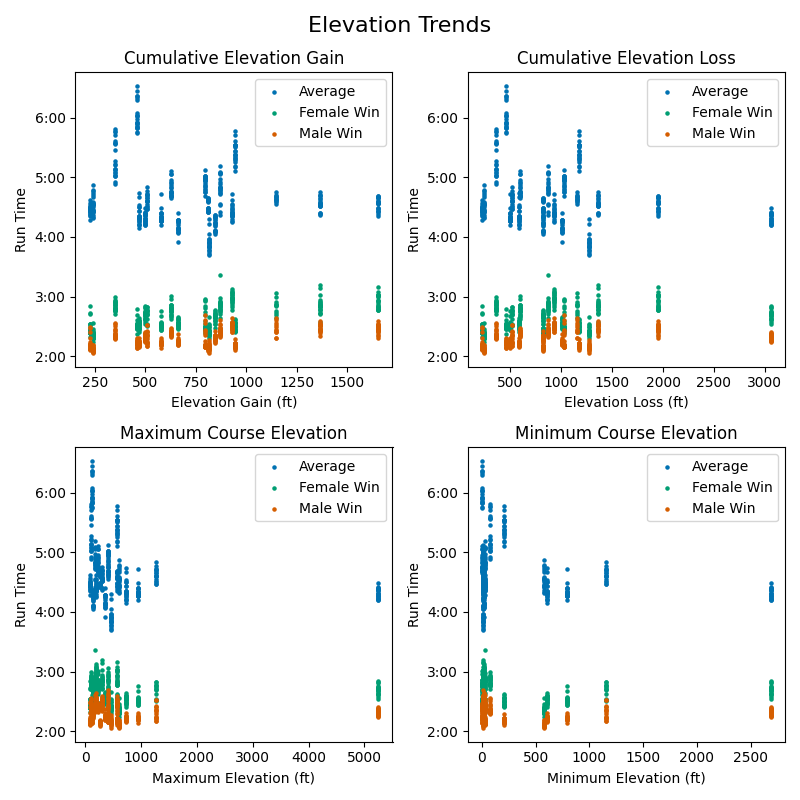

In [15]:
# Plot elevation data
# 'Elev Gain', 'Elev Loss',
# 'Elev Max', 'Elev Min', 
fig, axs = plt.subplots(2,2,figsize=(8,8))
((ax1,ax2),(ax3,ax4)) = axs

ax1.scatter(full_df['Elev Gain'],y_average, s=5, label='Average')
ax1.scatter(full_df['Elev Gain'],y_female, s=5, label='Female Win')
ax1.scatter(full_df['Elev Gain'],y_male, s=5, label='Male Win')
ax1.set_xlabel('Elevation Gain (ft)')
ax1.set_ylabel('Run Time')
ax1.set_title('Cumulative Elevation Gain')

ax2.scatter(full_df['Elev Loss'],y_average, s=5, label='Average')
ax2.scatter(full_df['Elev Loss'],y_female, s=5, label='Female Win')
ax2.scatter(full_df['Elev Loss'],y_male, s=5, label='Male Win')
ax2.set_xlabel('Elevation Loss (ft)')
ax2.set_ylabel('Run Time')
ax2.set_title('Cumulative Elevation Loss')

ax3.scatter(full_df['Elev Max'],y_average, s=5, label='Average')
ax3.scatter(full_df['Elev Max'],y_female, s=5, label='Female Win')
ax3.scatter(full_df['Elev Max'],y_male, s=5, label='Male Win')
ax3.set_xlabel('Maximum Elevation (ft)')
ax3.set_ylabel('Run Time')
ax3.set_title('Maximum Course Elevation')

ax4.scatter(full_df['Elev Min'],y_average, s=5, label='Average')
ax4.scatter(full_df['Elev Min'],y_female, s=5, label='Female Win')
ax4.scatter(full_df['Elev Min'],y_male, s=5, label='Male Win')
ax4.set_xlabel('Minimum Elevation (ft)')
ax4.set_ylabel('Run Time')
ax4.set_title('Minimum Course Elevation')

# Set tick labels and legends
for ax in [ax1,ax2,ax3,ax4]:
    ax.yaxis.set_major_locator(mticker.MultipleLocator(base=3600))
    ax.yaxis.set_major_formatter(formatter)
    ax.legend()

fig.suptitle('Elevation Trends', fontsize=16)

fig.tight_layout()

## Objective 1: Are variations in average marathon times connected to race conditions?

### Modeling Setup

In [16]:
# Load full data
directory = 'full_df_csvs'
newest_full_df = [file for file in sorted(os.listdir(directory)) if file.endswith('.csv')][-1]
full_df = pd.read_csv(os.path.join(directory, newest_full_df))

# Update data types
full_df['Date'] = pd.to_datetime(full_df['Date'])
time_cols = ['Male Win','Female Win','Average Time','Time STD']
full_df[time_cols] = (full_df[time_cols].apply(pd.to_timedelta))

# full_df.dtypes

#### Option A: Train-test split uses mix of all dates

In [17]:
# Train-test split is random
from sklearn.model_selection import train_test_split

# Feature Variables (Excludes these cols from the df: 'Event Name', 'City', 'State')
X = full_df[[
            'Date', 'Finishers', 'Males', 'Females', 'Percent Female', 
            'Elev Gain', 'Elev Loss', 'Elev Max', 'Elev Min', 
            'STATION', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 
            'TEMP', 'MAX', 'MIN', 'PRCP', 'DEWP', 'WDSP', 'RELHUM'
            ]]
# Dates will be in days (float) since Jan 1, 2000
X['Date'] = (pd.to_datetime(X['Date']) - pd.to_datetime('2000-01-01'))/np.timedelta64(1, 'D')

# Target Variables: Run times will be in seconds (float)
y_average = full_df['Average Time'] / np.timedelta64(1, 's')
y_male = full_df['Male Win'] / np.timedelta64(1, 's')
y_female = full_df['Female Win'] / np.timedelta64(1, 's')

X_ave_train, X_ave_test, y_ave_train, y_ave_test = train_test_split(X, y_average, random_state=0)
X_f_train, X_f_test, y_f_train, y_f_test = train_test_split(X, y_female, random_state=0)
X_m_train, X_m_test, y_m_train, y_m_test = train_test_split(X, y_male, random_state=0)

# X.dtypes
# y_average.dtypes

In [18]:
print(f'Total events: {len(X)}')
print(f'Train events: {len(X_ave_train)}')
print(f'Test events: {len(X_ave_test)}')
print(f'Split Fraction: {len(X_ave_test)/len(X)}')

Total events: 406
Train events: 304
Test events: 102
Split Fraction: 0.2512315270935961


#### Option B: Train on 2000-2015 and Test on 2016-2022

In [19]:
# # Train-test split is by Date
# train_df = full_df[full_df['Date'] < pd.to_datetime('2016-01-01')].sort_values('Date')
# test_df = full_df[full_df['Date'] >= pd.to_datetime('2016-01-01')].sort_values('Date')

# # Dates will be in days (float) since Jan 1, 2000
# train_df['Date'] = (pd.to_datetime(train_df['Date']) - pd.to_datetime('2000-01-01'))/np.timedelta64(1, 'D')
# test_df['Date'] = (pd.to_datetime(test_df['Date']) - pd.to_datetime('2000-01-01'))/np.timedelta64(1, 'D')

# # Feature Variables
# features = [#'Event Name', 'City', 'State', 
#             'Date', 
#             'Finishers', 'Males', 'Females', 'Percent Female',
#             'Elev Gain', 'Elev Loss', 'Elev Max', 'Elev Min', 
#             'STATION', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 
#             'TEMP', 'MAX', 'MIN', 'PRCP', 'DEWP', 'WDSP', 'RELHUM'
#             ]

# X_ave_train = train_df[features]
# X_f_train = X_ave_train
# X_m_train = X_ave_train

# X_ave_test = test_df[features]
# X_f_test = X_ave_test
# X_m_test = X_ave_test

# # Target Variables: Run times will be in seconds (float)
# y_ave_train = train_df['Average Time'] / np.timedelta64(1, 's')
# y_m_train = train_df['Male Win'] / np.timedelta64(1, 's')
# y_f_train = train_df['Female Win'] / np.timedelta64(1, 's')

# y_ave_test = test_df['Average Time'] / np.timedelta64(1, 's')
# y_m_test = test_df['Male Win'] / np.timedelta64(1, 's')
# y_f_test = test_df['Female Win'] / np.timedelta64(1, 's')

In [20]:
# print(f'Total events: {len(X_ave_test)+len(X_ave_train)}')
# print(f'Train events: {len(X_ave_train)}')
# print(f'Test events: {len(X_ave_test)}')
# print(f'Split Fraction: {len(X_ave_test)/(len(X_ave_test)+len(X_ave_train))}')

# # full_df
# # test_df
# # y_ave_train

### Linear Regression with Cross Validation

In [21]:
# Scale the input features based on medians and inter-quartile ranges
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_ave_train_scaled = scaler.fit_transform(X_ave_train)
# we must apply the scaling to the test set that we computed for the training set
X_ave_test_scaled = scaler.transform(X_ave_test)

In [22]:
# Create summary df to store scores and model coefficients
summary_df = pd.DataFrame(columns=['Params','Train R2','Test R2','CV R2 mean','CV R2 stdev',
                                   'Train RMSE','Test RMSE','Intercept']+list(X_ave_train.columns))

In [23]:
# Linear Regression with K-fold cross-validation
from sklearn.linear_model import LinearRegression, Ridge, Lasso

# Create a CV instance that shuffles
shuffle_cv = KFold(n_splits=5, shuffle=True, random_state=0)

# Linear Regression on train split with 5-fold cross validation
linreg_ave_cv = cross_val_score(LinearRegression(), X_ave_train_scaled, y_ave_train, cv=shuffle_cv)

# Linear Regression on whole train split
linreg_ave = LinearRegression().fit(X_ave_train_scaled, y_ave_train)

# Populate results in summary df
summary_df.loc['Linear Ave','Train R2'] = linreg_ave.score(X_ave_train_scaled, y_ave_train)
summary_df.loc['Linear Ave','Test R2'] = linreg_ave.score(X_ave_test_scaled, y_ave_test)
summary_df.loc['Linear Ave','CV R2 mean'] = np.mean(linreg_ave_cv)
summary_df.loc['Linear Ave','CV R2 stdev'] = np.std(linreg_ave_cv)
summary_df.loc['Linear Ave','Intercept'] = linreg_ave.intercept_
summary_df.loc['Linear Ave'].iloc[8:] = linreg_ave.coef_

# Calculate residuals and RMSE in minutes
linear_train_resid = (y_ave_train - linreg_ave.predict(X_ave_train_scaled))/60
linear_test_resid = (y_ave_test - linreg_ave.predict(X_ave_test_scaled))/60
summary_df.loc['Linear Ave','Train RMSE'] = ((linear_train_resid**2).mean())**0.5
summary_df.loc['Linear Ave','Test RMSE'] = ((linear_test_resid**2).mean())**0.5

summary_df

,Params,Train R2,Test R2,CV R2 mean,CV R2 stdev,Train RMSE,Test RMSE,Intercept,Date,Finishers,...,LATITUDE,LONGITUDE,ELEVATION,TEMP,MAX,MIN,PRCP,DEWP,WDSP,RELHUM
Linear Ave,NaN,0.772337,0.761092,0.696343,0.048797,14.051733,16.020429,16726.815789,53.185244,-111421.362917,...,-808.963331,-640.60482,414.905265,640.730613,-174.869227,-295.478994,49.940839,252.544323,-195.294002,-0.255997


### Ridge and Lasso Regression with Grid Search Cross-validation

In [24]:
# Ridge Regression: Grid Search with K-fold cross-validation

# Create CV instance and hyperparameter grid values
shuffle_cv = KFold(n_splits=5, shuffle=True, random_state=0)
grid_values = {'alpha': [0.01, 0.1, 1, 10]}

# Perform grid search cv on the train split
ridge_ave = Ridge(random_state=0)
grid_ridge_ave = GridSearchCV(ridge_ave, param_grid = grid_values, cv=shuffle_cv)
grid_ridge_ave.fit(X_ave_train_scaled, y_ave_train)
grid_ridge_ave_df = pd.DataFrame(grid_ridge_ave.cv_results_)

# Populate results in summary df
summary_df.loc['Ridge Ave','Params'] = [grid_ridge_ave.best_params_]
summary_df.loc['Ridge Ave','Train R2'] = grid_ridge_ave.best_estimator_.score(X_ave_train_scaled, y_ave_train)
summary_df.loc['Ridge Ave','Test R2'] = grid_ridge_ave.best_estimator_.score(X_ave_test_scaled, y_ave_test)
summary_df.loc['Ridge Ave','CV R2 mean'] = grid_ridge_ave.best_score_
summary_df.loc['Ridge Ave','CV R2 stdev'] = grid_ridge_ave_df.loc[grid_ridge_ave.best_index_,'std_test_score']
summary_df.loc['Ridge Ave','Intercept'] = grid_ridge_ave.best_estimator_.intercept_
summary_df.loc['Ridge Ave'].iloc[8:] = grid_ridge_ave.best_estimator_.coef_

# Calculate residuals and RMSE in minutes
ridge_train_resid = (y_ave_train - grid_ridge_ave.predict(X_ave_train_scaled))/60
ridge_test_resid = (y_ave_test - grid_ridge_ave.predict(X_ave_test_scaled))/60
summary_df.loc['Ridge Ave','Train RMSE'] = ((ridge_train_resid**2).mean())**0.5
summary_df.loc['Ridge Ave','Test RMSE'] = ((ridge_test_resid**2).mean())**0.5

summary_df

,Params,Train R2,Test R2,CV R2 mean,CV R2 stdev,Train RMSE,Test RMSE,Intercept,Date,Finishers,...,LATITUDE,LONGITUDE,ELEVATION,TEMP,MAX,MIN,PRCP,DEWP,WDSP,RELHUM
Linear Ave,NaN,0.772337,0.761092,0.696343,0.048797,14.051733,16.020429,16726.815789,53.185244,-111421.362917,...,-808.963331,-640.60482,414.905265,640.730613,-174.869227,-295.478994,49.940839,252.544323,-195.294002,-0.255997
Ridge Ave,[{'alpha': 0.1}],0.770101,0.760004,0.720597,0.038381,14.120561,16.056862,16726.815789,58.714563,107.55109,...,-796.903941,-625.178728,378.507836,515.324202,-158.246054,-219.51438,51.963693,311.615544,-200.311948,-60.447346


In [25]:
# View Grid Search data table if desired by uncommenting
# pd.DataFrame(grid_ridge_ave.cv_results_)

In [26]:
# Lasso Regression: Grid Search with K-fold cross-validation

# Create CV instance and hyperparameter grid values
shuffle_cv = KFold(n_splits=5, shuffle=True, random_state=0)
grid_values = {'alpha': [0.01, 0.1, 1, 10]}

# Perform grid search cv on the train split
lasso_ave = Lasso(random_state=0)
grid_lasso_ave = GridSearchCV(lasso_ave, param_grid = grid_values, cv=shuffle_cv)
grid_lasso_ave.fit(X_ave_train_scaled, y_ave_train)
grid_lasso_ave_df = pd.DataFrame(grid_lasso_ave.cv_results_)

# Populate results in summary df
summary_df.loc['Lasso Ave','Params'] = [grid_lasso_ave.best_params_]
summary_df.loc['Lasso Ave','Train R2'] = grid_lasso_ave.best_estimator_.score(X_ave_train_scaled, y_ave_train)
summary_df.loc['Lasso Ave','Test R2'] = grid_lasso_ave.best_estimator_.score(X_ave_test_scaled, y_ave_test)
summary_df.loc['Lasso Ave','CV R2 mean'] = grid_lasso_ave.best_score_
summary_df.loc['Lasso Ave','CV R2 stdev'] = grid_lasso_ave_df.loc[grid_lasso_ave.best_index_,'std_test_score']
summary_df.loc['Lasso Ave','Intercept'] = grid_lasso_ave.best_estimator_.intercept_
summary_df.loc['Lasso Ave'].iloc[8:] = grid_lasso_ave.best_estimator_.coef_

# Calculate residuals and RMSE in minutes
lasso_train_resid = (y_ave_train - grid_lasso_ave.predict(X_ave_train_scaled))/60
lasso_test_resid = (y_ave_test - grid_lasso_ave.predict(X_ave_test_scaled))/60
summary_df.loc['Lasso Ave','Train RMSE'] = ((lasso_train_resid**2).mean())**0.5
summary_df.loc['Lasso Ave','Test RMSE'] = ((lasso_test_resid**2).mean())**0.5

summary_df

/Users/michael/Documents/PythonCoding/environments/datasci5/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.929e+07, tolerance: 7.778e+04
  model = cd_fast.enet_coordinate_descent(
/Users/michael/Documents/PythonCoding/environments/datasci5/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.966e+07, tolerance: 7.835e+04
  model = cd_fast.enet_coordinate_descent(
/Users/michael/Documents/PythonCoding/environments/datasci5/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to inc

,Params,Train R2,Test R2,CV R2 mean,CV R2 stdev,Train RMSE,Test RMSE,Intercept,Date,Finishers,...,LATITUDE,LONGITUDE,ELEVATION,TEMP,MAX,MIN,PRCP,DEWP,WDSP,RELHUM
Linear Ave,NaN,0.772337,0.761092,0.696343,0.048797,14.051733,16.020429,16726.815789,53.185244,-111421.362917,...,-808.963331,-640.60482,414.905265,640.730613,-174.869227,-295.478994,49.940839,252.544323,-195.294002,-0.255997
Ridge Ave,[{'alpha': 0.1}],0.770101,0.760004,0.720597,0.038381,14.120561,16.056862,16726.815789,58.714563,107.55109,...,-796.903941,-625.178728,378.507836,515.324202,-158.246054,-219.51438,51.963693,311.615544,-200.311948,-60.447346
Lasso Ave,[{'alpha': 1}],0.769705,0.760624,0.723293,0.038615,14.132723,16.036119,16726.815789,56.730196,0.0,...,-789.821666,-612.156063,355.055165,488.628005,-125.222744,-183.846268,49.506413,269.966705,-201.669937,-37.244729


In [27]:
# View Grid Search data table if desired by uncommenting
# pd.DataFrame(grid_lasso_ave.cv_results_)

### Gradient Boosting and Random Forest Tree Ensembles with Grid Search Cross-validation

In [28]:
# Gradient Boosting Tree Ensembles: Grid Search with K-fold cross-validation

# Create KFold CV instance and hyperparameter grid values
shuffle_cv = KFold(n_splits=5, shuffle=True, random_state=0)
grid_values = {'max_depth': [1, 2, 3, 4],
               'learning_rate': [0.01, 0.02, 0.05, 0.1, 0.2],
               'n_estimators': [50, 100, 150, 200, 250]}

# Perform grid search cv on the train split
gb_ave = GradientBoostingRegressor(random_state=0)
grid_gb_ave = GridSearchCV(gb_ave, param_grid = grid_values, cv=shuffle_cv)
grid_gb_ave.fit(X_ave_train, y_ave_train)
grid_gb_ave_df = pd.DataFrame(grid_gb_ave.cv_results_)

# Populate results in summary df
summary_df.loc['Gradient Boosting Ave','Params'] = [grid_gb_ave.best_params_]
summary_df.loc['Gradient Boosting Ave','Train R2'] = grid_gb_ave.best_estimator_.score(X_ave_train, y_ave_train)
summary_df.loc['Gradient Boosting Ave','Test R2'] = grid_gb_ave.best_estimator_.score(X_ave_test, y_ave_test)
summary_df.loc['Gradient Boosting Ave','CV R2 mean'] = grid_gb_ave.best_score_
summary_df.loc['Gradient Boosting Ave','CV R2 stdev'] = grid_gb_ave_df.loc[grid_gb_ave.best_index_,'std_test_score']

# Calculate residuals and RMSE in minutes
gb_train_resid = (y_ave_train - grid_gb_ave.predict(X_ave_train))/60
gb_test_resid = (y_ave_test - grid_gb_ave.predict(X_ave_test))/60
summary_df.loc['Gradient Boosting Ave','Train RMSE'] = ((gb_train_resid**2).mean())**0.5
summary_df.loc['Gradient Boosting Ave','Test RMSE'] = ((gb_test_resid**2).mean())**0.5

print(f'Best Gradient Boosting Model Paramters: {grid_gb_ave.best_params_}')
summary_df

Best Gradient Boosting Model Paramters: {'learning_rate': 0.2, 'max_depth': 1, 'n_estimators': 250}


,Params,Train R2,Test R2,CV R2 mean,CV R2 stdev,Train RMSE,Test RMSE,Intercept,Date,Finishers,...,LATITUDE,LONGITUDE,ELEVATION,TEMP,MAX,MIN,PRCP,DEWP,WDSP,RELHUM
Linear Ave,NaN,0.772337,0.761092,0.696343,0.048797,14.051733,16.020429,16726.815789,53.185244,-111421.362917,...,-808.963331,-640.60482,414.905265,640.730613,-174.869227,-295.478994,49.940839,252.544323,-195.294002,-0.255997
Ridge Ave,[{'alpha': 0.1}],0.770101,0.760004,0.720597,0.038381,14.120561,16.056862,16726.815789,58.714563,107.55109,...,-796.903941,-625.178728,378.507836,515.324202,-158.246054,-219.51438,51.963693,311.615544,-200.311948,-60.447346
Lasso Ave,[{'alpha': 1}],0.769705,0.760624,0.723293,0.038615,14.132723,16.036119,16726.815789,56.730196,0.0,...,-789.821666,-612.156063,355.055165,488.628005,-125.222744,-183.846268,49.506413,269.966705,-201.669937,-37.244729
Gradient Boosting Ave,"[{'learning_rate': 0.2, 'max_depth': 1, 'n_est...",0.976153,0.93377,0.936253,0.018465,4.54782,8.43501,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
# View best grid search data series if desired by uncommenting
# pd.DataFrame(grid_gb_ave.cv_results_).loc[grid_gb_ave.best_index_]

In [30]:
# Random Forest Tree Ensembles: Grid Search with K-fold cross-validation

# Create KFold CV instance and hyperparameter grid values
shuffle_cv = KFold(n_splits=5, shuffle=True, random_state=0)
grid_values = {'max_features': [0.2, 0.3, 0.4, 0.6, 0.8, 1.0],
               'max_samples': [0.6, 0.8, 1.0]}

# Perform grid search cv on the train split
rf_ave = RandomForestRegressor(n_estimators=250, random_state=0)
grid_rf_ave = GridSearchCV(rf_ave, param_grid = grid_values, cv=shuffle_cv)
grid_rf_ave.fit(X_ave_train, y_ave_train)
grid_rf_ave_df = pd.DataFrame(grid_rf_ave.cv_results_)

# Populate results in summary df
summary_df.loc['Random Forest Ave','Params'] = [grid_rf_ave.best_params_]
summary_df.loc['Random Forest Ave','Train R2'] = grid_rf_ave.best_estimator_.score(X_ave_train, y_ave_train)
summary_df.loc['Random Forest Ave','Test R2'] = grid_rf_ave.best_estimator_.score(X_ave_test, y_ave_test)
summary_df.loc['Random Forest Ave','CV R2 mean'] = grid_rf_ave.best_score_
summary_df.loc['Random Forest Ave','CV R2 stdev'] = grid_rf_ave_df.loc[grid_rf_ave.best_index_,'std_test_score']

# Calculate residuals and RMSE in minutes
rf_train_resid = (y_ave_train - grid_rf_ave.predict(X_ave_train))/60
rf_test_resid = (y_ave_test - grid_rf_ave.predict(X_ave_test))/60
summary_df.loc['Random Forest Ave','Train RMSE'] = ((rf_train_resid**2).mean())**0.5
summary_df.loc['Random Forest Ave','Test RMSE'] = ((rf_test_resid**2).mean())**0.5

print(f'Best Random Forest Model Paramters: {grid_rf_ave.best_params_}')
summary_df

Best Random Forest Model Paramters: {'max_features': 0.6, 'max_samples': 1.0}


,Params,Train R2,Test R2,CV R2 mean,CV R2 stdev,Train RMSE,Test RMSE,Intercept,Date,Finishers,...,LATITUDE,LONGITUDE,ELEVATION,TEMP,MAX,MIN,PRCP,DEWP,WDSP,RELHUM
Linear Ave,NaN,0.772337,0.761092,0.696343,0.048797,14.051733,16.020429,16726.815789,53.185244,-111421.362917,...,-808.963331,-640.60482,414.905265,640.730613,-174.869227,-295.478994,49.940839,252.544323,-195.294002,-0.255997
Ridge Ave,[{'alpha': 0.1}],0.770101,0.760004,0.720597,0.038381,14.120561,16.056862,16726.815789,58.714563,107.55109,...,-796.903941,-625.178728,378.507836,515.324202,-158.246054,-219.51438,51.963693,311.615544,-200.311948,-60.447346
Lasso Ave,[{'alpha': 1}],0.769705,0.760624,0.723293,0.038615,14.132723,16.036119,16726.815789,56.730196,0.0,...,-789.821666,-612.156063,355.055165,488.628005,-125.222744,-183.846268,49.506413,269.966705,-201.669937,-37.244729
Gradient Boosting Ave,"[{'learning_rate': 0.2, 'max_depth': 1, 'n_est...",0.976153,0.93377,0.936253,0.018465,4.54782,8.43501,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Random Forest Ave,"[{'max_features': 0.6, 'max_samples': 1.0}]",0.993026,0.949048,0.941806,0.016268,2.459433,7.398395,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
# View best grid search data series if desired by uncommenting
# pd.DataFrame(grid_rf_ave.cv_results_).loc[grid_rf_ave.best_index_]

### Plot Performance of Tree Ensembles

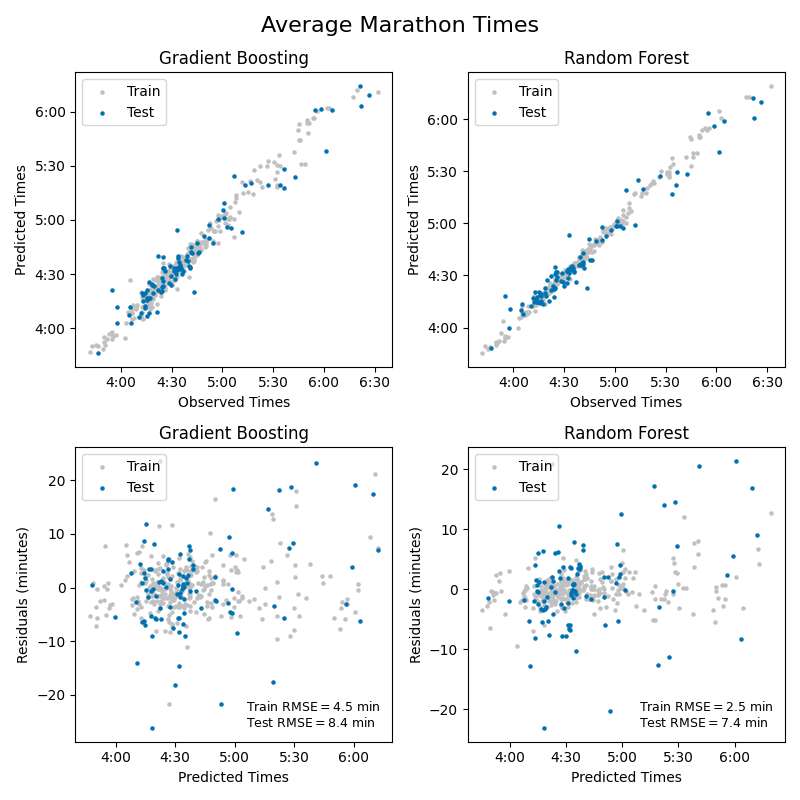

In [32]:
fig, axs = plt.subplots(2,2,figsize=(8,8))
((ax1,ax2),(ax3,ax4)) = axs

y_ave_test_gb = grid_gb_ave.predict(X_ave_test)
y_ave_train_gb = grid_gb_ave.predict(X_ave_train)

ax1.scatter(y_ave_train,y_ave_train_gb, s=5, label='Train', color='silver')
ax1.scatter(y_ave_test,y_ave_test_gb, s=5, label='Test')
ax1.set_xlabel('Observed Times')
ax1.set_ylabel('Predicted Times')
ax1.set_title('Gradient Boosting')

y_ave_test_rf = grid_rf_ave.predict(X_ave_test)
y_ave_train_rf = grid_rf_ave.predict(X_ave_train)

ax2.scatter(y_ave_train,y_ave_train_rf, s=5, label='Train', color='silver')
ax2.scatter(y_ave_test,y_ave_test_rf, s=5, label='Test')
ax2.set_xlabel('Observed Times')
ax2.set_ylabel('Predicted Times')
ax2.set_title('Random Forest')

ax3.scatter(y_ave_train_gb, gb_train_resid, s=5, label='Train', color='silver')
ax3.scatter(y_ave_test_rf, gb_test_resid, s=5, label='Test')
ax3.set_xlabel('Predicted Times')
ax3.set_ylabel('Residuals (minutes)')
ax3.set_title('Gradient Boosting')

ax4.scatter(y_ave_train_rf, rf_train_resid, s=5, label='Train', color='silver')
ax4.scatter(y_ave_test_rf, rf_test_resid, s=5, label='Test')
ax4.set_xlabel('Predicted Times')
ax4.set_ylabel('Residuals (minutes)')
ax4.set_title('Random Forest')

# Create annotations for fit metrics
gb_note = AnchoredText(f"Train RMSE$={summary_df.loc['Gradient Boosting Ave','Train RMSE']:.1f}$ min\nTest RMSE$={summary_df.loc['Gradient Boosting Ave','Test RMSE']:.1f}$ min",
                     prop=dict(size=9), frameon=False, loc='lower right')
rf_note = AnchoredText(f"Train RMSE$={summary_df.loc['Random Forest Ave','Train RMSE']:.1f}$ min\nTest RMSE$={summary_df.loc['Random Forest Ave','Test RMSE']:.1f}$ min",
                     prop=dict(size=9), frameon=False, loc='lower right')
ax3.add_artist(gb_note)
ax4.add_artist(rf_note)

# Set tick labels and legends
for ax in [ax1,ax2]:
    ax.yaxis.set_major_locator(mticker.MultipleLocator(base=1800))
    ax.yaxis.set_major_formatter(formatter)
    ax.xaxis.set_major_locator(mticker.MultipleLocator(base=1800))
    ax.xaxis.set_major_formatter(formatter)
    ax.legend(loc='upper left')
for ax in [ax3,ax4]:
    ax.xaxis.set_major_locator(mticker.MultipleLocator(base=1800))
    ax.xaxis.set_major_formatter(formatter)
    ax.legend(loc='upper left')

fig.suptitle('Average Marathon Times', fontsize=16)

fig.tight_layout()

## Objective 2: Are winning marathon times connected to weather and elevation similar to average runner times?

## Objective 3: How can an average runner adjust their pacing plan to account for race day conditions?

### Effect of each variable on race times

In [33]:
# Create df to highlight which race factors are most beneficial and detrimental
coef_df = (summary_df.loc['Ridge Ave'].iloc[8:]
           .to_frame()
           .sort_values('Ridge Ave')
           .rename(columns={'Ridge Ave':'Coef'})
          )

# Function to categorize race factors on how they affect average race time
def good_or_bad(coef):
    cutoff = 200
    if coef > cutoff: return 'Detrimental'
    elif coef < -cutoff: return 'Beneficial'
    else: return 'Low-Impact'
coef_df['Effect'] = coef_df['Coef'].apply(good_or_bad)

# To allow interpretation of coefficients, we will reverse the StandardScaler.
# StandardScaler transformation performed using training std dev to convert to unscaled coefs.
stdev_df = X_ave_train.std().to_frame()
stdev_df.columns = ['St Dev']
coef_df = coef_df.merge(stdev_df, how='inner', left_index=True, right_index=True)
coef_df['Unscaled Coef'] = coef_df.apply(lambda x: x['Coef']/x['St Dev'], axis=1)

print('\nSpeeds up Ave Time:')
print(coef_df[coef_df['Effect']=='Beneficial'].loc[:,['Coef','Unscaled Coef']])
print('\nSlows down Ave Time:')
print(coef_df[coef_df['Effect']=='Detrimental'].loc[:,['Coef','Unscaled Coef']]
     .sort_values('Coef', ascending=False))
print('\nLow-Impact on Ave Time:')
print(coef_df[coef_df['Effect']=='Low-Impact'].loc[:,['Coef','Unscaled Coef']])
print('\n\nHighlights:')
coef_df.loc[['Date','TEMP','DEWP','RELHUM','PRCP','WDSP',
             'ELEVATION','Elev Gain','Elev Loss'],
            ['Effect','Coef','Unscaled Coef']
           ].sort_values('Coef')


Speeds up Ave Time:
                  Coef  Unscaled Coef
Elev Min  -2237.629337      -3.646749
Elev Loss -2223.888481      -3.604465
LATITUDE   -796.903941    -117.430433
LONGITUDE  -625.178728     -27.841441
MIN         -219.51438     -21.148524
WDSP       -200.311948     -56.394886

Slows down Ave Time:
                       Coef  Unscaled Coef
Elev Max        3210.551994       3.033443
Elev Gain       1005.497903       3.081212
TEMP             515.324202      51.629236
Males            509.213726       0.074095
Percent Female   416.046175      70.432979
ELEVATION        378.507836       1.655354
DEWP             311.615544      26.156744

Low-Impact on Ave Time:
                 Coef  Unscaled Coef
MAX       -158.246054  -1.394022e+01
Females   -106.798647  -2.211591e-02
RELHUM     -60.447346  -3.490096e+00
STATION    -45.342979  -1.153446e-08
PRCP        51.963693   2.633152e+02
Date        58.714563   2.554044e-02
Finishers   107.55109   9.306654e-03


Highlights:


,Effect,Coef,Unscaled Coef
Elev Loss,Beneficial,-2223.888481,-3.604465
WDSP,Beneficial,-200.311948,-56.394886
RELHUM,Low-Impact,-60.447346,-3.490096
PRCP,Low-Impact,51.963693,263.315176
Date,Low-Impact,58.714563,0.025540
DEWP,Detrimental,311.615544,26.156744
ELEVATION,Detrimental,378.507836,1.655354
TEMP,Detrimental,515.324202,51.629236
Elev Gain,Detrimental,1005.497903,3.081212


### Not used: Gradient Boosting and Random Forest Decision Tree: Default Parameters

In [ ]:
# Gradient Boosting Tree Ensembles: Default parameters
from sklearn.ensemble import GradientBoostingRegressor

print('Gradient Boosting Regressors')

# Average Times
print('\n   Average Run Times')
gb_ave = GradientBoostingRegressor(max_depth=3, random_state=0)
gb_ave.fit(X_ave_train, y_ave_train)
print(f'Train Score: {gb_ave.score(X_ave_train, y_ave_train)}')
print(f'Test Score: {gb_ave.score(X_ave_test, y_ave_test)}')

# Female Wins
print('\n   Female Win Times')
gb_female = GradientBoostingRegressor(max_depth=3, random_state=0)
gb_female.fit(X_f_train, y_f_train)
print(f'Train Score: {gb_female.score(X_f_train, y_f_train)}')
print(f'Test Score: {gb_female.score(X_f_test, y_f_test)}')

# Male Wins
print('\n   Male Win Times')
gb_male = GradientBoostingRegressor(max_depth=3, random_state=0)
gb_male.fit(X_m_train, y_m_train)
print(f'Train Score: {gb_male.score(X_m_train, y_m_train)}')
print(f'Test Score: {gb_male.score(X_m_test, y_m_test)}')

# reg.predict(X_test[1:2])

In [ ]:
# Gradient Boosting Regressors

#    Average Run Times
# Train Score: 0.993531533363386
# Test Score: 0.8689688733102867

#    Female Win Times
# Train Score: 0.9711857846763055
# Test Score: 0.618034174759329

#    Male Win Times
# Train Score: 0.9650934605583189
# Test Score: 0.7489883911130311

In [ ]:
# Random Forest Regressors: Default parameters
from sklearn.ensemble import RandomForestRegressor

print('Random Forest Regressors')

# Average Times
print('\n   Average Run Times')
rf_ave = RandomForestRegressor(max_depth=None, random_state=0)
rf_ave.fit(X_ave_train, y_ave_train)
print(f'Train Score: {rf_ave.score(X_ave_train, y_ave_train)}')
print(f'Test Score: {rf_ave.score(X_ave_test, y_ave_test)}')

# Female Wins
print('\n   Female Win Times')
rf_female = RandomForestRegressor(max_depth=None, random_state=0)
rf_female.fit(X_f_train, y_f_train)
print(f'Train Score: {rf_female.score(X_f_train, y_f_train)}')
print(f'Test Score: {rf_female.score(X_f_test, y_f_test)}')

# Male Wins
print('\n   Male Win Times')
rf_male = RandomForestRegressor(max_depth=None, random_state=0)
rf_male.fit(X_m_train, y_m_train)
print(f'Train Score: {rf_male.score(X_m_train, y_m_train)}')
print(f'Test Score: {rf_male.score(X_m_test, y_m_test)}')

# print(regr.predict([[0, 0, 0, 0]]))

In [ ]:
# Random Forest Regressors

#    Average Run Times
# Train Score: 0.9950461265261321
# Test Score: 0.8829037493416145

#    Female Win Times
# Train Score: 0.9748012400958829
# Test Score: 0.7060348888283718

#    Male Win Times
# Train Score: 0.9764619108264133
# Test Score: 0.780094416964991

### Not used: Tree Ensembles with Time-Series Cross-validation

In [ ]:
# Training split uses time-series cross validation
from sklearn.model_selection import TimeSeriesSplit

ts_cv = TimeSeriesSplit(n_splits=5)
all_splits = list(ts_cv.split(X_ave_train, y_ave_train))
train_0, test_0 = all_splits[0]
train_4, test_4 = all_splits[-1]
# X_ave_train.iloc[test_0]
print(len(train_0))
print(len(test_0))
print(len(train_4))
print(len(test_4))

In [ ]:
# Gradient Boosting Tree Ensembles: Grid Search with Time Series cross-validator
from sklearn.model_selection import GridSearchCV
# Training split uses time-series cross validation
from sklearn.model_selection import TimeSeriesSplit

ts_cv = TimeSeriesSplit(n_splits=5, max_train_size=50)
grid_values = {'max_depth': [1, 2, 3, 4],
               'learning_rate': [0.01, 0.02, 0.05, 0.1, 0.2],
               'n_estimators': [50, 100, 150, 200, 250]}

gb_cv_ave = GradientBoostingRegressor(random_state=0)
grid_gb_ave = GridSearchCV(gb_cv_ave, param_grid = grid_values, cv=ts_cv)
grid_gb_ave.fit(X_ave_train, y_ave_train)

print(f'Best Paramters (squared error): {grid_gb_ave.best_params_}')
print(f'Best Score (R^2): {grid_gb_ave.best_score_}')
print(f'Test Set Score (R^2): {grid_gb_ave.score(X_ave_test, y_ave_test)}')

In [ ]:
# max_train_size=None:
# Best Paramters (squared error): {'learning_rate': 0.2, 'max_depth': 1, 'n_estimators': 250}
# Best Score (R^2): 0.9135540160845889
# Test Set Score (R^2): 0.8725139194984939

# max_train_size=100:
# Best Paramters (squared error): {'learning_rate': 0.2, 'max_depth': 1, 'n_estimators': 250}
# Best Score (R^2): 0.909646140631061
# Test Set Score (R^2): 0.8725139194984939

# max_train_size=50:
# Best Paramters (squared error): {'learning_rate': 0.2, 'max_depth': 1, 'n_estimators': 250}
# Best Score (R^2): 0.9049604776085655
# Test Set Score (R^2): 0.8725139194984939

In [ ]:
print(grid_gb_ave.cv_results_.keys())
print(len(grid_gb_ave.cv_results_['param_learning_rate']))
pd.DataFrame(grid_gb_ave.cv_results_).iloc[-5:]

### Not used: Checking which variables are most important

#### Option A: Train-test split uses mix of all dates

In [ ]:
# Train-test split is random
from sklearn.model_selection import train_test_split

# Feature Variables
X_check = full_df[[#'Event Name', 'City', 'State', 
            'Date', 
            'Finishers', 'Males', 'Females', 'Percent Female',
            'Elev Gain', 'Elev Loss', 'Elev Max', 'Elev Min',
            'STATION', 'LATITUDE', 'LONGITUDE', 'ELEVATION',
            'TEMP', 'MAX', 'MIN', 'PRCP', 'DEWP', 'WDSP', 'RELHUM'
            ]]

# Dates will be in days (float) since Jan 1, 2000
X_check['Date'] = (pd.to_datetime(X_check['Date']) - pd.to_datetime('2000-01-01'))/np.timedelta64(1, 'D')

# Target Variables: Run times will be in seconds (float)
y_check_average = full_df['Average Time'] / np.timedelta64(1, 's')
y_check_male = full_df['Male Win'] / np.timedelta64(1, 's')
y_check_female = full_df['Female Win'] / np.timedelta64(1, 's')

X_check_ave_train, X_check_ave_test, y_check_ave_train, y_check_ave_test = train_test_split(X_check, y_check_average, random_state=0)
X_check_f_train, X_check_f_test, y_check_f_train, y_check_f_test = train_test_split(X_check, y_check_female, random_state=0)
X_check_m_train, X_check_m_test, y_check_m_train, y_check_m_test = train_test_split(X_check, y_check_male, random_state=0)

# X_check.dtypes
# y_check_average.dtypes

In [ ]:
print(f'Total events: {len(X_check)}')
print(f'Train events: {len(X_check_ave_train)}')
print(f'Test events: {len(X_check_ave_test)}')
print(f'Split Fraction: {len(X_check_ave_test)/len(X_check)}')

#### Tree Ensembles with Cross-validation

In [ ]:
# Gradient Boosting Tree Ensembles: Grid Search with K-fold cross-validator
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
# Training split uses K-fold cross validation
from sklearn.model_selection import KFold

shuffle_cv = KFold(n_splits=5, shuffle=True, random_state=0)
grid_values = {'max_depth': [1, 2, 3, 4],
               'learning_rate': [0.01, 0.02, 0.05, 0.1, 0.2],
               'n_estimators': [50, 100, 150, 200, 250]}

gb_check_ave = GradientBoostingRegressor(random_state=0)
grid_gb_check_ave = GridSearchCV(gb_check_ave, param_grid = grid_values, cv=shuffle_cv)
grid_gb_check_ave.fit(X_check_ave_train, y_check_ave_train)

print(f'Best Paramters (squared error): {grid_gb_check_ave.best_params_}')
print(f'Best Score (R^2): {grid_gb_check_ave.best_score_}')
print(f'Test Set Score (R^2): {grid_gb_check_ave.score(X_check_ave_test, y_check_ave_test)}')

In [ ]:
# 2016-2022 Test (102/406), With shuffle=True, random_state=0:__
# Best Paramters (squared error): {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 250}
# Best Score (R^2): 0.9579724218584735
# Test Set Score (R^2): 0.8746660975538072

# Sample all years Test, With shuffle=True, random_state=0:
# Best Paramters (squared error): {'learning_rate': 0.2, 'max_depth': 1, 'n_estimators': 250}
# Best Score (R^2): 0.936252871209456
# Test Set Score (R^2): 0.9337701946985129

In [ ]:
# Random Forest Tree Ensembles: Grid Search with K-fold cross-validator
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
# Training split uses K-fold cross validation
from sklearn.model_selection import KFold

shuffle_cv = KFold(n_splits=5, shuffle=True, random_state=0)
grid_values = {'max_features': [0.2, 0.25, 0.3, 0.35, 0.4, 0.6, 1.0],
               'max_samples': [0.6, 0.8, 1.0]}

rf_shuffle_ave = RandomForestRegressor(n_estimators=250, random_state=0)
grid_rf_ave = GridSearchCV(rf_shuffle_ave, param_grid = grid_values, cv=shuffle_cv)
grid_rf_ave.fit(X_check_ave_train, y_check_ave_train)

print(f'Best Paramters (squared error): {grid_rf_ave.best_params_}')
print(f'Best Score (R^2): {grid_rf_ave.best_score_}')
print(f'Test Set Score (R^2): {grid_rf_ave.score(X_check_ave_test, y_check_ave_test)}')

In [ ]:
# 2016-2022 Test (102/406), With shuffle=True, random_state=0:__
# Best Paramters (squared error): {'max_features': 0.3, 'max_samples': 1.0}
# Best Score (R^2): 0.9626093498998685
# Test Set Score (R^2): 0.8831137496257951

In [ ]:
# Create df to store model performance metrics
summary_df = pd.DataFrame(columns={'Train R2':[],'Test R2':[],
                            'Train RMSE':[],'Test RMSE':[],'Train MAE':[],'Test MAE':[]})

# Calculate R2 values
summary_df.loc['Gradient Boosting Ave','Train R2'] = grid_gb_check_ave.score(X_check_ave_train, y_check_ave_train)
summary_df.loc['Gradient Boosting Ave','Test R2'] = grid_gb_check_ave.score(X_check_ave_test, y_check_ave_test)
summary_df.loc['Random Forest Ave','Train R2'] = grid_rf_ave.score(X_check_ave_train, y_check_ave_train)
summary_df.loc['Random Forest Ave','Test R2'] = grid_rf_ave.score(X_check_ave_test, y_check_ave_test)

# Calculate residuals, MAE, and RMSE
gb_train_resid = (y_check_ave_train - grid_gb_check_ave.predict(X_check_ave_train))/60
gb_test_resid = (y_check_ave_test - grid_gb_check_ave.predict(X_check_ave_test))/60
rf_train_resid = (y_check_ave_train - grid_rf_ave.predict(X_check_ave_train))/60
rf_test_resid = (y_check_ave_test - grid_rf_ave.predict(X_check_ave_test))/60

summary_df.loc['Gradient Boosting Ave','Train MAE'] = (np.absolute(gb_train_resid)).mean()
summary_df.loc['Gradient Boosting Ave','Test MAE'] = (np.absolute(gb_test_resid)).mean()
summary_df.loc['Random Forest Ave','Train MAE'] = (np.absolute(rf_train_resid)).mean()
summary_df.loc['Random Forest Ave','Test MAE'] = (np.absolute(rf_test_resid)).mean()

summary_df.loc['Gradient Boosting Ave','Train RMSE'] = ((gb_train_resid**2).mean())**0.5
summary_df.loc['Gradient Boosting Ave','Test RMSE'] = ((gb_test_resid**2).mean())**0.5
summary_df.loc['Random Forest Ave','Train RMSE'] = ((rf_train_resid**2).mean())**0.5
summary_df.loc['Random Forest Ave','Test RMSE'] = ((rf_test_resid**2).mean())**0.5

# Set 'Model' and 'Train/Test' cols
# summary_df['Model'] = summary_df.index
# summary_df['Train/Test'] = summary_df.apply(lambda x: (x.Model).split()[1], axis=1)
# summary_df['Model'] = summary_df.apply(lambda x: (x.Model).split()[0], axis=1)

summary_df

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(8,8))
((ax1,ax2),(ax3,ax4)) = axs

y_check_ave_test_gb = grid_gb_check_ave.predict(X_check_ave_test)
y_check_ave_train_gb = grid_gb_check_ave.predict(X_check_ave_train)

ax1.scatter(y_check_ave_train,y_check_ave_train_gb, s=5, label='Train: 2000-2015', color='silver')
ax1.scatter(y_check_ave_test,y_check_ave_test_gb, s=5, label='Test: 2016-2022')
ax1.set_xlabel('True Times')
ax1.set_ylabel('Predicted Times')
ax1.set_title('Gradient Boosting')

y_check_ave_test_rf = grid_rf_ave.predict(X_check_ave_test)
y_check_ave_train_rf = grid_rf_ave.predict(X_check_ave_train)

ax2.scatter(y_check_ave_train,y_check_ave_train_rf, s=5, label='Train: 2000-2015', color='silver')
ax2.scatter(y_check_ave_test,y_check_ave_test_rf, s=5, label='Test: 2016-2022')
ax2.set_xlabel('True Times')
ax2.set_ylabel('Predicted Times')
ax2.set_title('Random Forest')

ax3.scatter(y_check_ave_train, gb_train_resid, s=5, label='Train: 2016-2022', color='silver')
ax3.scatter(y_check_ave_test, gb_test_resid, s=5, label='Test: 2016-2022')
ax3.set_xlabel('True Times')
ax3.set_ylabel('Residuals (minutes)')
ax3.set_title('Gradient Boosting')

ax4.scatter(y_check_ave_train, rf_train_resid, s=5, label='Train: 2016-2022', color='silver')
ax4.scatter(y_check_ave_test, rf_test_resid, s=5, label='Test: 2016-2022')
ax4.set_xlabel('True Times')
ax4.set_ylabel('Residuals (minutes)')
ax4.set_title('Random Forest')

# Create annotations for fit metrics
gb_note = AnchoredText(f"Test MAE$={summary_df.loc['Gradient Boosting Ave','Test MAE']:.1f}$ min\nTest RMSE$={summary_df.loc['Gradient Boosting Ave','Test RMSE']:.1f}$ min",
                     prop=dict(size=9), frameon=False, loc='lower right')
rf_note = AnchoredText(f"Test MAE$={summary_df.loc['Random Forest Ave','Test MAE']:.1f}$ min\nTest RMSE$={summary_df.loc['Random Forest Ave','Test RMSE']:.1f}$ min",
                     prop=dict(size=9), frameon=False, loc='lower right')
ax3.add_artist(gb_note)
ax4.add_artist(rf_note)

# Set tick labels and legends
for ax in [ax1,ax2]:
    ax.yaxis.set_major_locator(mticker.MultipleLocator(base=1800))
    ax.yaxis.set_major_formatter(formatter)
    ax.xaxis.set_major_locator(mticker.MultipleLocator(base=1800))
    ax.xaxis.set_major_formatter(formatter)
    ax.legend()
for ax in [ax3,ax4]:
    ax.xaxis.set_major_locator(mticker.MultipleLocator(base=1800))
    ax.xaxis.set_major_formatter(formatter)
    ax.legend()

fig.suptitle('Average Marathon Times', fontsize=16)

fig.tight_layout()

### To Implement:

__Objective 1__
1. Unpack grid_gb_ave.cv_results_ in pandas to plot parameter trends


__Objective 2__
1. Fit and plot the female and male win times with grid search using tree ensembles

